# This project is a Kaggle Competition: Natural Language Processing with Disaster Tweets

## This project can be divided into four parts:

#### part 1: Exploratory data analysis
#### part 2: Data preprocessing
#### part 3: Feature Selection
#### Part 4: Model training and testing

## Achievements
#### Before starting on my project, I studied a kaggle competitor's work because I think he did an excellent work in data preprocessing and most of data preprocessing in my project are from his work. However, this project is not a duplicate of his. Here are something that can differetiate my work from others:
    ##### Before data preprocessing, inconsistent records (the same Xs with different y labels) are deleted from  
    training data and duplicating  records are deduplicated.
    #### Among all of techniques of data preprocessing, a different feature extraction method (TFDIF) is used to generate features
    #### Pincipal Component Analysis, GridSearchCV are used to find the optimal model performance
    #### Two feature selection methods were applied to improve SVC model performance
    
## Future Improvement
#### dimension reduction - backward elimination or forward selection or t-SNE can be tried 
#### Feature engineering - N-grams can be tried 
#### Other model: Deep learning models can be tried

In [77]:
import numpy as np # linear algebra
import pandas as pd # data preprocessing
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from collections import Counter
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import emoji
import contractions
from spellchecker import SpellChecker
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

import collections


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.decomposition import PCA, NMF


from typing import Text, Dict, List, Union, Tuple, Optional, Set

[nltk_data] Downloading package stopwords to /Users/liyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/liyu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/liyu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/liyu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [33]:
# read the training data and testing data
train_df = pd.read_csv('./Downloads/train.csv')
test_df = pd.read_csv('./Downloads/test.csv')

In [34]:
# view the top 5 records of the training data
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [35]:
# There are 7613 records.
train_df.shape

(7613, 5)

In [36]:
# It seems that the column - text has duplicated records.
train_df.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

### Remove duplicating records and non-consistent labeling records

In [37]:
# It shows that some records even duplicate more than 5 times.
# Let's check if these duplicating recores have consistent label.
train_df.groupby(['text']).size().sort_values(ascending=False)[:5]

text
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...        10
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_     6
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                               6
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                      6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives                                                                                  5
dtype: int64

In [38]:
# All of duplicating records has consistent target value. Let's check other duplicating records the same.
train_df.loc[train_df['text']=='11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...']

,id,keyword,location,text,target
3578,5113,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of T...,1
3589,5127,fatal,Varanasi,11-Year-Old Boy Charged With Manslaughter of T...,1
3591,5130,fatal,Thane,11-Year-Old Boy Charged With Manslaughter of T...,1
3597,5137,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of T...,1
3600,5140,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of T...,1
3603,5144,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of T...,1
3604,5145,fatal,Bangalore,11-Year-Old Boy Charged With Manslaughter of T...,1
3610,5153,fatal,Dimapur,11-Year-Old Boy Charged With Manslaughter of T...,1
3613,5157,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of T...,1
3614,5159,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of T...,1


In [39]:
train_df.groupby(['text','target']).size().sort_values(ascending=False)[:5]

text                                                                                                                                          target
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...      1         10
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_  1          6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives                                                                               1          5
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                   0          4
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                            0          4
dtype: int64

In [40]:
# Let's deduplicate the train.
train_df.drop_duplicates(subset=['text','target'],inplace=True)

In [41]:
train_df.reset_index(inplace=True)

In [42]:
train_df.index

RangeIndex(start=0, stop=7521, step=1)

In [43]:
# Let's double check if there are still duplicating records
# Some text has in-consistent label. We should delete these records.
delete_text = train_df.groupby(['text']).size().sort_values(ascending=False)[:19].reset_index().iloc[:18,0].tolist()
train_df = train_df.loc[~train_df['text'].isin(delete_text)]

In [44]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7485 entries, 0 to 7520
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     7485 non-null   int64 
 1   id        7485 non-null   int64 
 2   keyword   7429 non-null   object
 3   location  5013 non-null   object
 4   text      7485 non-null   object
 5   target    7485 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 409.3+ KB


####  column - keyword has 0.8% missing values and column - location has 33% missing values

#### column - id is a number unique for each row, this column is not informative so that we will exclude it in our analysis
#### column - keyword has 0.8% missing values, which is not too bad. We might include this in our analysis depending on how 
#### informative it is
#### column - location has 33% missing values. In machine learning, the way we handle missing values is to fill a value
#### for it using methods, which approximate an value close to its real value as much as possible. However, for location, 
#### all of methods are not applicable. So we are going to discard this column in our analysis.
#### Column - text, is the most import column, which is going to be used to generate variables to predict if a tweet is 
#### disaster or not
#### column - target is dependent column, containing eiter "0" or "1". "0" means this tweet is not reporting a real disaster.
#### "1" means this tweet is reporting a real disaster.

### Check if there is data imbalance problem

In [45]:
# Check if the data has data imbalance problem
train_df.target.value_counts()

0    4297
1    3188
Name: target, dtype: int64

<AxesSubplot:title={'center':'Pie chart of Disaster/Non-disaster tweets'}, ylabel='target'>

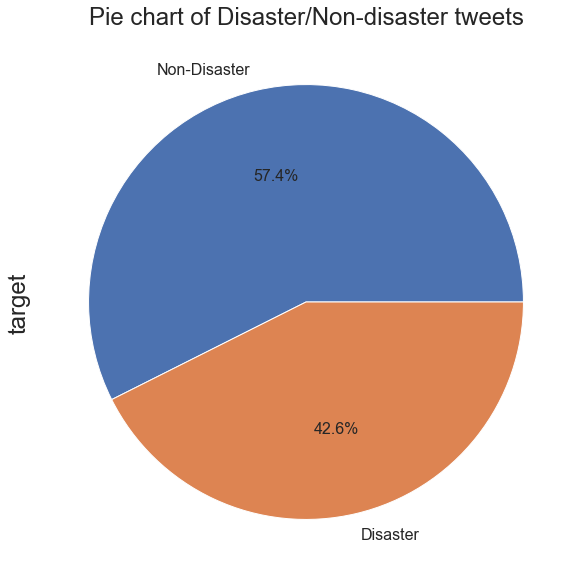

In [46]:
# # visualize the target column distribution
train_df['target'].value_counts().plot(kind='pie', title='Pie chart of Disaster/Non-disaster tweets',
                                       autopct='%1.1f%%', shadow=False,
                                       labels=['Non-Disaster','Disaster'],
                                       legend=False, fontsize=16, figsize=(10,10))

#### the training data has slight imbalance. 

### Column - keyword analysis and visualization

In [47]:
# Check if column - keyword has only one word for each record
# The column - keyword has exact one word,
train_df.keyword.dropna().str.split().map(lambda x: len(x)).nunique()

1

In [48]:
# There are 221 keywords
train_df.keyword.nunique()

221

<AxesSubplot:>

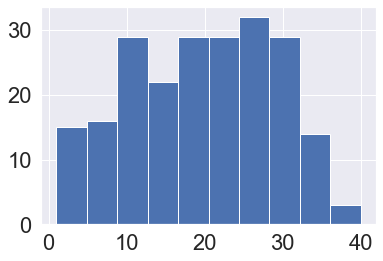

In [49]:
train_df[train_df['target']==0].keyword.dropna().value_counts().sort_values(ascending=False).hist()

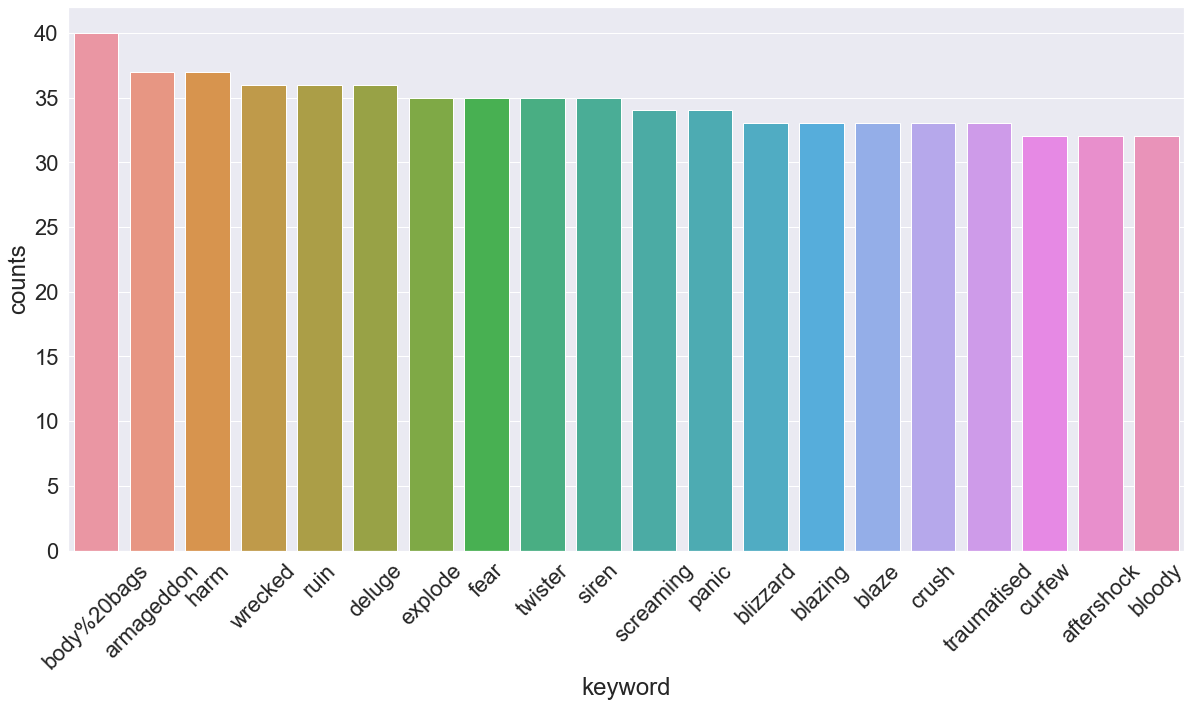

In [19]:
# For non-disaster reports, what do the top 20 keywords look like?
non_disaster_keyword = train_df[train_df['target']==0].keyword.dropna().value_counts()[:20]\
.sort_values(ascending=False).reset_index().rename({'keyword':'counts','index':'keyword'},axis=1)
plt.figure(figsize=(20,10))
sns.set(font_scale=2)
bar_plot = sns.barplot(x="keyword", y = "counts", data = non_disaster_keyword)
plt.xticks(rotation=45)
plt.show()

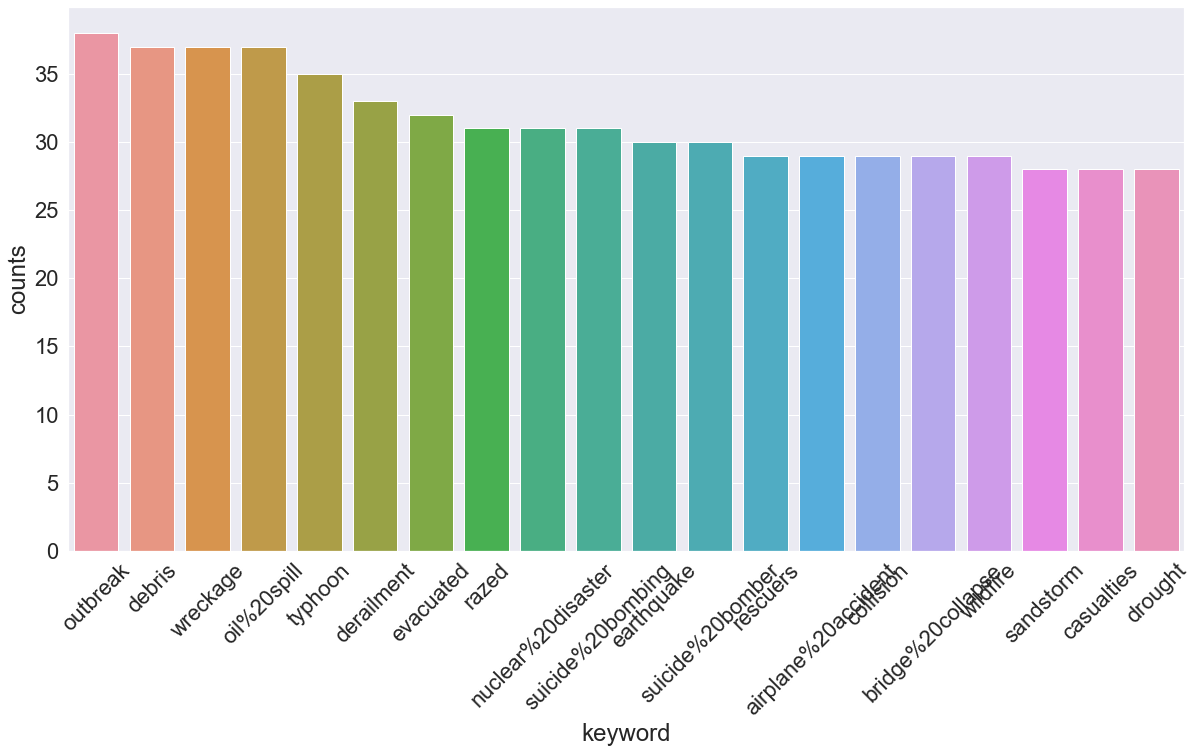

In [20]:
# For disaster reports, what do the top 20 keywords look like?
disaster_keyword = train_df[train_df['target']==1].keyword.dropna().value_counts()[:20]\
.sort_values(ascending=False).reset_index().rename({'keyword':'counts','index':'keyword'},axis=1)
plt.figure(figsize=(20,10))
sns.set(font_scale = 2)
bar_plot = sns.barplot(x="keyword", y = "counts", data = disaster_keyword)
plt.xticks(rotation=45)
plt.show()

### Column - text include important information to classify disaster and non-disaster. However, before using it, we need to preprocess it.

###  For text data preprocessing, I would like to thank: @Ahmed on Kaggle because most of data preprocessing techniques come from his great work because I can't find any better and more comprehensive works than his. 
### For text data preprocessing, I just copy code from @Ahmed and run it on my notebook. By reading and running code line by line, I got inspired and had deeper understanding about how to analyze text data.

#### No.1: Parse the Hashtags
Thanks to @Ahmed, @sudalairajkumar

#### What do hashtags mean?
hashtag was added to the Oxford English Dictionary as "a word or phrase with the symbol # in front of it, used on social media websites and apps so that you can search for all messages with the same subject"

In [50]:
# Groups are marked by the '(', ')' metacharacters.
# they group together the expressions contained inside them, and you can repeat the contents of a group 
# with a repeating qualifier, such as *, +, ?, or {m,n}. For example, (ab)* will match zero or more 
# repetitions of ab.
# 'w' - matches any letter, digit and underscore character
# '+' - matches one or more times
# '?' - matches zero or one time
# '*' - matches zero or more times
# re.compile - Compile a regular expression pattern into a regular expression object, which can be used 
# for matching using its match(), search() and other methods
# re.sub(pattern, repl, string, count=0, flags=0). r'\2 \4' - only keep the text part

def parse_hashtags(text: Text) -> Text:
    hashtag=re.compile(r'(\#)(\w+)(_)(\w+)', re.IGNORECASE)
    text = hashtag.sub(r'\2 \4',text)
    return text.replace('_', ' ')

In [51]:
train_df['text'] = train_df['text'].apply(lambda sentence: parse_hashtags(sentence))
test_df['text'] = test_df['text'].apply(lambda sentence: parse_hashtags(sentence))

####  No.2: Remove markdown links
Thanks to @Ahmed, @sudalairajkumar

In [70]:
# Actually when trying to search the markdown link in both training data and testing data
# it returns "None". 
# .* - any characters with any number repeating
# .*? - with matching successful, use the least repeating
# \[.*?] - [any characters with any length without changing line]
# \(.*?\) -(any characters with any lenght without changing line)
# Markdown links: []\()
def md_links(text: Text) -> Text:
    markdown_link=re.compile(r'\[.*?\]\(.*?\)')
    return markdown_link.sub(r'',text)

In [71]:
train_df['text'] = train_df['text'].apply(lambda sentence: md_links(sentence))
test_df['text'] = test_df['text'].apply(lambda sentence: md_links(sentence))

#### No.3: remove links 
Thanks to @Ahmed, @sudalairajkumar

In [72]:
# https? - "?" mean s appear either zero or one, which matches either "https" or "http"
# \s (lowercase s) matches a whitespace (blank, tab \t, and newline \r or \n)
# On the other hand, the \S+ (uppercase S) matches anything that is NOT matched by \s
# In regex, the uppercase metacharacter denotes the inverse of the lowercase counterpart, 
# for example, \w for word character and \W for non-word character; \d for digit and \D or non-digit.
# \S|www\. - "|" means "or". \. - matches "."
def scrape_links(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [73]:
train_df['text'] = train_df['text'].apply(lambda sentence: scrape_links(sentence))
test_df['text'] = test_df['text'].apply(lambda sentence: scrape_links(sentence))

#### No4: dealing with emoji
Thanks to @Ahmed, @sudalairajkumar
#### Normally, emoj represent the report's emotion. Nobody will post a smail on disaster report. So Emoji can be a hint of disaster and non-disaster tweet.

In [77]:
def is_emoji(text: Text)-> bool:
    for label in text:
        if label in emoji.UNICODE_EMOJI_ENGLISH:
            return True
    return False

In [78]:
# It shows that there are only 0.13% records having emoji. It can scrapped from the text.
is_emoji_train = train_df['text'].apply(lambda sentence: is_emoji(sentence))
is_emoji_train.value_counts()

/var/folders/9q/_4z53kt172d5xvsdd7vnrwdh0000gp/T/ipykernel_8184/3767349667.py:3: DeprecationWarning: 'emoji.UNICODE_EMOJI_ENGLISH' is deprecated and will be removed in version 2.0.0. Use 'emoji.EMOJI_DATA' instead.
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  if label in emoji.UNICODE_EMOJI_ENGLISH:


False    7475
True       10
Name: text, dtype: int64

In [87]:
# Scrapping Emoji
def decode_emoji(text: Text) -> Text:
    txt_emoji_list = emoji.distinct_emoji_lis(text) # get distinct emoji
    rx = '[' + re.escape(''.join(txt_emoji_list)) + ']' # regular expression object

    if not txt_emoji_list:
        return text
    elif '©' not in txt_emoji_list:
        return re.sub(rx, '', text) +\
        ''.join([emoji.demojize(emoj).replace(':', ' ') for emoj in txt_emoji_list])
    elif ('©' in txt_emoji_list and len(txt_emoji_list) == 1):
        return text.replace('©', '')
    elif ('©' in txt_emoji_list and len(txt_emoji_list) > 1):
        text = text.replace('©', '')
        return re.sub(rx, '', text) +\
        ''.join([emoji.demojize(emoj).replace(':', ' ') for emoj in txt_emoji_list])

In [88]:
train_df['text'] = train_df['text'].apply(lambda sentence: decode_emoji(sentence))
test_df['text'] = test_df['text'].apply(lambda sentence: decode_emoji(sentence))

/var/folders/9q/_4z53kt172d5xvsdd7vnrwdh0000gp/T/ipykernel_8184/1730804926.py:3: DeprecationWarning: 'emoji.distinct_emoji_lis()' is deprecated and will be removed in version 2.0.0. Use method emoji.distinct_emoji_list(str) instead.
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  txt_emoji_list = emoji.distinct_emoji_lis(text) # get distinct emoji


#### No.5 : Dealing with Emoticons
Thanks to @Ahmed, @sudalairajkumar

In [89]:
# Thanks : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [92]:
# What is the percentage of Emoticons?
# There are 6.8% Emoticons. It can be converted to text

def is_emot(text: Text)-> bool:
    for emo in EMOTICONS:
        if re.search(emo, text):
                return True
    return False

is_emoji_train = train_df['text'].apply(lambda sentence: is_emot(sentence))
is_emoji_train.value_counts()

False    6971
True      514
Name: text, dtype: int64

In [94]:
is_emot_train = train_df['text'].apply(lambda sentence: is_emot(sentence))
is_emot_test = test_df['text'].apply(lambda sentence: is_emot(sentence))

In [96]:
def convert_emoticons_distinct(text: Text) -> Text:
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    
    # follow ref: https://stackoverflow.com/a/57231478/14473118
    # \b - word boundary
    # (\w+\s*) - one or more word chars \w+ followed by any number of whitespace characters \s* 
    # - enclosed into a captured group (...)
    # \1{1,} - refers to the 1st captured group occurred one or more times {1,}
    text = re.sub(r'\b(\w+\s*)\1{1,}', '\\1', text, re.IGNORECASE)
    return text

In [98]:
train_df.loc[is_emot_train, 'text'] = train_df.loc[is_emot_train, 'text'].apply(lambda sentence: convert_emoticons_distinct(sentence))
test_df.loc[is_emot_test, 'text'] = test_df.loc[is_emot_test, 'text'].apply(lambda sentence: convert_emoticons_distinct(sentence))

#### No.6: English contractions
Thanks to @Ahmed, @sudalairajkumar
#### English contractions example: He would=He’d. I have=I’ve. They are=They’re. You cannot=You can’t.

In [99]:
def en_contractions(text: Text) -> Text:
    return ' '.join([contractions.fix(word)
                     if word in contractions.contractions_dict else word
                     for word in text.split()])

In [102]:
train_df['text'] = train_df['text'].apply(lambda sentence: en_contractions(sentence))
test_df['text'] = test_df['text'].apply(lambda sentence: en_contractions(sentence))

#### No.7: Dealing with Tags
Thanks to @Ahmed, @sudalairajkumar

In [103]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [104]:
train_df['text'] = train_df['text'].apply(lambda sentence: remove_html(sentence))
test_df['text'] = test_df['text'].apply(lambda sentence: remove_html(sentence))

#### No.8 : Chat Words Conversion
Thanks to @Ahmed, @sudalairajkumar

In [105]:
CHAT_WORDS_STR = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [106]:
# First, we're going to convert this long string into set of words and its shortcut
chat_words_map_dict = {}
chat_shortcut_list = set()
for line in CHAT_WORDS_STR.split("\n"):
    if line != '':
        shortcut = line.split('=')[0] # split the line from `=` sign and select shortcut
        chat_words = line.split('=')[1]
        chat_shortcut_list.add(shortcut) # add the chat  shortcut to the set
        chat_words_map_dict[shortcut] = chat_words # add each chat_words corresponding to its shortcut

chat_words_map_dict

{'AFAIK': 'As Far As I Know',
 'AFK': 'Away From Keyboard',
 'ASAP': 'As Soon As Possible',
 'ATK': 'At The Keyboard',
 'ATM': 'At The Moment',
 'A3': 'Anytime, Anywhere, Anyplace',
 'BAK': 'Back At Keyboard',
 'BBL': 'Be Back Later',
 'BBS': 'Be Back Soon',
 'BFN': 'Bye For Now',
 'B4N': 'Bye For Now',
 'BRB': 'Be Right Back',
 'BRT': 'Be Right There',
 'BTW': 'By The Way',
 'B4': 'Before',
 'CU': 'See You',
 'CUL8R': 'See You Later',
 'CYA': 'See You',
 'FAQ': 'Frequently Asked Questions',
 'FC': 'Fingers Crossed',
 'FWIW': "For What It's Worth",
 'FYI': 'For Your Information',
 'GAL': 'Get A Life',
 'GG': 'Good Game',
 'GN': 'Good Night',
 'GMTA': 'Great Minds Think Alike',
 'GR8': 'Great!',
 'G9': 'Genius',
 'IC': 'I See',
 'ICQ': 'I Seek you (also a chat program)',
 'ILU': 'ILU: I Love You',
 'IMHO': 'In My Honest/Humble Opinion',
 'IMO': 'In My Opinion',
 'IOW': 'In Other Words',
 'IRL': 'In Real Life',
 'KISS': 'Keep It Simple, Stupid',
 'LDR': 'Long Distance Relationship',
 'LM

In [107]:
def chat_words_conversion(text: Text) -> Text:
    new_text = []
    for word in text.split():
        if word.upper() in chat_words_map_dict:
            new_text.append(chat_words_map_dict[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)

In [108]:
train_df['text'] = train_df['text'].apply(lambda sentence: chat_words_conversion(sentence))
test_df['text'] = test_df['text'].apply(lambda sentence: chat_words_conversion(sentence))

#### No.9: Dealing with Special Characters
Thanks to @Ahmed, @sudalairajkumar

In [109]:
s_chars = '¥₽ÏïŰŬĎŸæ₿₪ÚŇÀèÅ”ĜåŽÖéříÿý€ŝĤ₹áŜŮÂ₴ûÌÇšŘúüëÓ₫ŠčÎŤÆÒœ₩öËäøÍťìĈôàĥÝ¢ç“žðÙÊĉŭÈŒÐÉÔĵùÁů„âÄűĴóêĝÞîØòď฿ČÜþňÛ'
PUNC = '+@«#_\-!$%%^&*¬()£<>?/\\|}\]\[{;\,~:\"\''

In [110]:
def special_char(text: Text) -> Text:
    # first, let's remove any unicode strings
    text = text.encode('ascii', 'ignore').decode()
    # remove printable bachslashes
    text = re.sub(r'[\t\s\n\r\b\a]', ' ', text)
    # Special letters
    text = re.sub(r'[{}]'.format(s_chars), '', text)
    # Punctuation
    text = re.sub(r'[{}]'.format(PUNC), ' ', text)
    # space at the start or the end of the context
    text = re.sub(r'(^\s)|(\s$)', '', text)
    # Single character
    text = re.sub(r'(\s[^iIaA]\s)', ' ', text)
    return text

In [111]:
train_df['text'] = train_df['text'].apply(lambda sentence: special_char(sentence))
test_df['text'] = test_df['text'].apply(lambda sentence: special_char(sentence))

#### No.10:  remove numbers
Thanks to @Ahmed, @sudalairajkumar

In [112]:
train_df['text'] = train_df['text'].str.replace('\d+', '', regex=True)
test_df['text'] = test_df['text'].str.replace('\d+', '', regex=True)

#### No.11:  Special Cases
Thanks to @Ahmed, @sudalairajkumar

In [114]:
# replace "yr" with "year"
train_df['text'] = train_df['text'].str.replace("yr", 'year', regex=False)
test_df['text'] = test_df['text'].str.replace("yr", 'year', regex=False)

In [115]:
# replace special characters,[. == = ' ` PM, AM UTC] with whitespace

train_df['text'] = train_df['text'].str.replace(r"\.|==|=|'|`|(PM)|(AM)|(UTC)", ' ', regex=True)
test_df['text'] = test_df['text'].str.replace(r"\.|==|=|'|`|(PM)|(AM)|(UTC)", ' ', regex=True)

In [116]:
# replace "..." with whitespace
train_df['text'] = train_df['text'].str.replace("...", '', regex=False)
test_df['text'] = test_df['text'].str.replace("...", '', regex=False)

In [120]:
# if the single character between two whitespaces is not "i", "I","a","A", then replace them with whitespace.
train_df['text'] = train_df['text'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
test_df['text'] = test_df['text'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)

In [121]:
# $ - match the end of a string.
# ^ - match the start of a string
# \b - match the end of a word
train_df['text'] = train_df['text'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
test_df['text'] = test_df['text'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)

In [122]:
train_df['text'] = train_df['text'].str.replace(r'\s ', ' ', regex=True)
test_df['text'] = test_df['text'].str.replace(r'\s ', ' ', regex=True)

In [123]:
train_df['text'] = train_df['text'].str.replace(r'(^\s)|(\s$)', '', regex=True)
test_df['text'] = test_df['text'].str.replace(r'(^\s)|(\s$)', '', regex=True)

#### No.12: Spell Correction
Thanks to @Ahmed, @sudalairajkumar

In [126]:
# check how many words are misspelled
spelling = SpellChecker(distance=1)
def misspelt_words_fn(dataframe: pd.DataFrame, column: Text) -> Set[Text]:
    misspelt_words = set()
    for tweet in dataframe[column].str.casefold():
        [misspelt_words.add(word) for word in spelling.unknown(tweet.split())]
    return misspelt_words

In [128]:
misspelt_words = misspelt_words_fn(train_df, 'text')
len(misspelt_words)

5543

In [129]:
# Correct misspelled words
WORD = re.compile(r'\w+')
def reTokenize(tweet: Text) -> List[Text]:
    return WORD.findall(tweet.casefold())

PATTERN = re.compile(r"(.)\1{2,}")
def reduce_lengthening(text: Text) -> Text:
    return PATTERN.sub(r"\1\1", text)

In [130]:
def spell_correction(text: Text) -> Text:
    return ' '.join([spelling.correction(word)
                     if word in misspelt_words else word
                     for word in reTokenize(reduce_lengthening(text))])

In [132]:
train_df['corrected_text'] = train_df['text'].apply(lambda sentence: spell_correction(sentence))
test_df['corrected_text'] = test_df['text'].apply(lambda sentence: spell_correction(sentence))

In [136]:
misspelt_words_count = len(misspelt_words_fn(train_df, 'corrected_text'))
misspelt_words_count

3793

#### No.13: remove stop words
Thanks to @Ahmed, @sudalairajkumar

In [133]:
SWs = set(stopwords.words("english"))

In [134]:
def remove_stopwords(text: Text) -> Text:
    return " ".join([word for word in text.split()
                     if word not in SWs])

In [137]:
train_df['text_without_stopwords'] = train_df['corrected_text'].apply(lambda sentence: remove_stopwords(sentence))
test_df['text_without_stopwords'] = test_df['corrected_text'].apply(lambda sentence: remove_stopwords(sentence))

In [138]:
train_df[['corrected_text','text_without_stopwords']][:10]

,corrected_text,text_without_stopwords
0,our deeds are the reason of this earthquake ma...,deeds reason earthquake may allah forgive us
1,forest fire near la range ask canada,forest fire near la range ask canada
2,all residents asked to shelter in place are be...,residents asked shelter place notified officer...
3,people receive wildfires evacuation orders in ...,people receive wildfires evacuation orders cal...
4,just got sent this photo from ruby alaska as s...,got sent photo ruby alaska smoke wildfires pou...
5,rockyfire update california why closed in both...,rockyfire update california closed directions ...
6,flood disaster heavy rain causes flash floodin...,flood disaster heavy rain causes flash floodin...
7,i am on top of the hill and i can see a fire i...,top hill see fire woods
8,there an emergency evacuation happening now in...,emergency evacuation happening building across...
9,i am afraid that the tornado is coming to our ...,afraid tornado coming area


#### No.14: Lemmatization
Thanks to @Ahmed, @sudalairajkumar

In [145]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'J': wordnet.ADJ, 'R': wordnet.ADJ}
def adjusted_lemmatizer(text: Text) -> Text:
    # Split the snetence into words and each word with its type
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN))
                     for word, pos in pos_tagged_text])

In [148]:
train_df['text_lemmatized'] = train_df['text_without_stopwords'].apply(lambda sentence: adjusted_lemmatizer(sentence))
test_df['text_lemmatized'] = test_df['text_without_stopwords'].apply(lambda sentence: adjusted_lemmatizer(sentence))

#### No.15: Dealing with Frequent words/ Rare words
regarding this part, I have different opions on how to handle frequent and rare words from @Ahmed.
Here are two issues I think @Ahmed had in his notebook:
1. The author keep some words outside the frequent and rare words definition. I think the reason they can do that because the limited training data give them some hints what words could predict diaster and non-disaster well. However, imagine, we have much larger size training data or the training data being updated every day. It is a bias to keep the same words set outside the frequent and rare words. Also, it has risk of information leaskage by doing so.
2. When the authour handle the frequent and rare words, he did it on training data and testing data separately. According to my understanding, this is not right way. It should apply the same frequent and rare words which being acquired from training data to testing data.
3. TFDIF(Term Frequency and Inverse Document Frequency) can Term Frequency and Inverse Document Frequency

In [102]:
X_train = train_df.drop('target',axis=1)
y_train = train_df.target
X_test = test_df.copy()

In [103]:
tfvec = TfidfVectorizer()
X_tdf_train = tfvec.fit_transform(X_train['text_lemmatized'])
X_bow_train = pd.DataFrame(X_tdf_train.toarray(), columns = tfvec.get_feature_names())

In [104]:
X_bow_train.shape

(7485, 13284)

In [105]:
X_bow_train[:5]

,aaand,aall,aannd,aaronthefm,aarrgghh,aashiqui,ab,aba,abandon,abandonedpics,...,zombiefunrun,zone,zoom,zourryart,zrnf,zssconfusion,zumiez,zurich,zxathetis,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
X_test.dropna(inplace=True)

In [48]:
X_tdf_test = tfvec.transform(X_test['text_lemmatized'])
X_bow_test = pd.DataFrame(X_tdf_test.toarray(),columns = tfvec.get_feature_names())
X_bow_test.shape

(2158, 13284)

#### Dimensionality reduction, hyperparameter tunning, and model training using scikit-learn Pipeline.

##### We can see that the best model performance on training data is 70%, which is very low.

In [96]:
def model_train(X,y):
    # Define a Principal Component function to reduce the dimensionality
    pca = PCA()

    # set the tolerance to a large value to make the example faster
    SVC = svm.SVC(max_iter=10000)
    pipe = Pipeline(steps=[("pca", pca), ("svc", SVC)])

    # Parameters of pipelines can be set using ‘__’ separated parameter names:
    param_grid = {
        "pca__n_components": [100, 200, 300, 400, 500],
        "svc__C": [0.01, 0.1, 1, 10, 100],
        "svc__kernel" :['linear', 'rbf', 'poly']
    }
    search = GridSearchCV(pipe, param_grid)
    search.fit(X, y)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

In [107]:
model_train(X_bow_train, y_train)

/Users/liyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/liyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/liyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/liyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with Stand

Best parameter (CV score=0.705):
{'pca__n_components': 400, 'svc__C': 1, 'svc__kernel': 'rbf'}


#### Model Performance Improvement  - 1

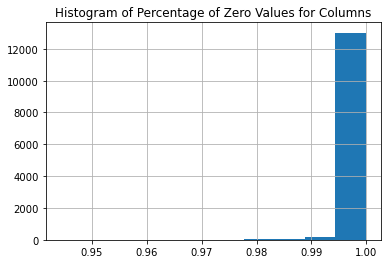

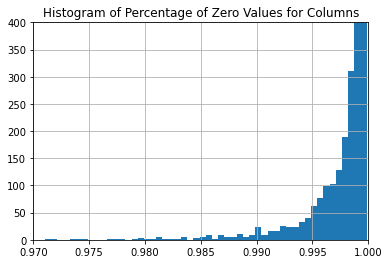

In [71]:
# To improve the model performance, let's check our features
# let's check the percentage of zero for each column. We can see it there is at least 97% zero values. 
# It is super sparse matrix. Let's choose those columns with percentage of zero values less than 99.5%
pd.Series(X_bow_train[X_bow_train == 0.0].count(axis=0)/len(X_bow_train.index))\
.to_frame().sort_values(by=0).hist()
plt.title("Histogram of Percentage of Zero Values for Columns")

pd.Series(X_bow_train[X_bow_train == 0.0].count(axis=0)/len(X_bow_train.index))\
.to_frame().sort_values(by=0).hist(bins=100)
plt.xlim(0.97,1.0)
plt.ylim(0,400)
plt.title("Histogram of Percentage of Zero Values for Columns")
plt.show()

In [72]:
# There are 318 records left after applying zero values control
S = pd.Series(X_bow_train[X_bow_train == 0.0].count(axis=0)/len(X_bow_train.index))
S = S[S <= 0.995]
S

accident    0.987174
affect      0.994656
air         0.994255
also        0.994255
always      0.994122
              ...   
wound       0.990114
wreck       0.989446
wreckage    0.994790
year        0.974349
youtube     0.987041
Length: 318, dtype: float64

In [74]:
# Keep column if column exist in S.index 
X_bow_train = X_bow_train.loc[:, X_bow_train.columns.isin(S.index)]
X_bow_test = X_bow_test.loc[:, X_bow_test.columns.isin(S.index)]

In [75]:
# Using updated training data to train SVC model again
# This method doesn't help the model performance
SVC = svm.SVC()
pipe = Pipeline(steps=[("svc", SVC)])
param_grid = {
    "svc__C": [0.01, 0.1, 1, 10, 100],
    "svc__kernel" :['linear', 'rbf', 'poly']
}
search = GridSearchCV(pipe, param_grid)
search.fit(X_bow_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.661):
{'svc__C': 1, 'svc__kernel': 'linear'}


#### Model Performance Improvement  - 2
 Maybe we should check what are the most frequent words for disaster tweets and non-disaster tweets

In [76]:
def words_count(df,target):
    corpus=[]
    
    for x in df[df['target']==target]['text_lemmatized'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [84]:
updated_feature_list=[]

[Text(0.5, 1.0, 'The top 50 most frequent words for non-disaster tweets')]

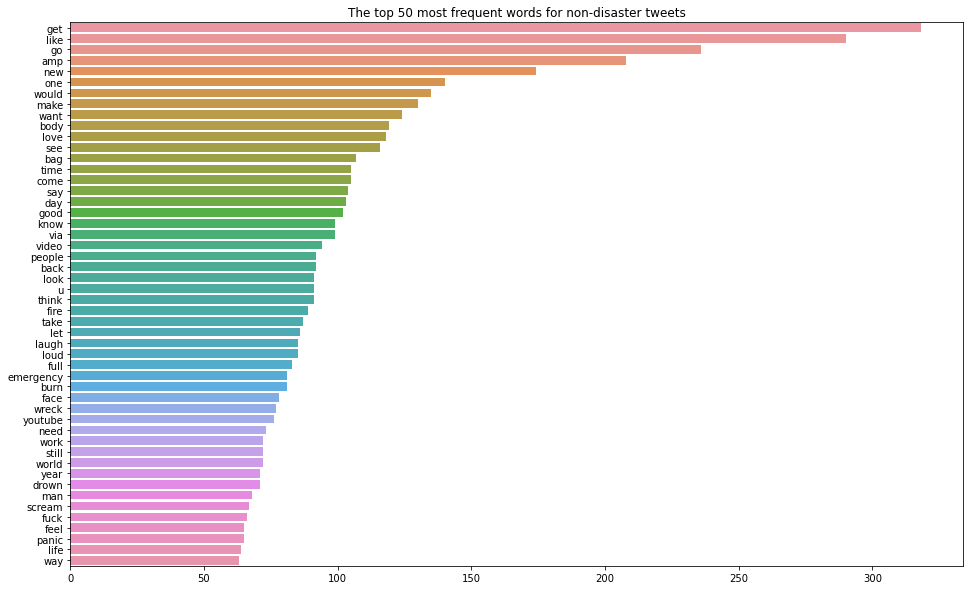

In [85]:
allWords_non_disaster=words_count(train_df,target=0)

plt.figure(figsize=(16,10))
counter=collections.Counter(allWords_non_disaster)
most_50_non_disaster=counter.most_common()
x=[]
y=[]
for word,count in most_50_non_disaster[:50]:
    x.append(word)
    y.append(count)
sns.barplot(x=y,y=x).set(title='The top 50 most frequent words for non-disaster tweets')

In [86]:
updated_feature_list.append(x)

[Text(0.5, 1.0, 'The top 50 most frequent words for disaster tweets')]

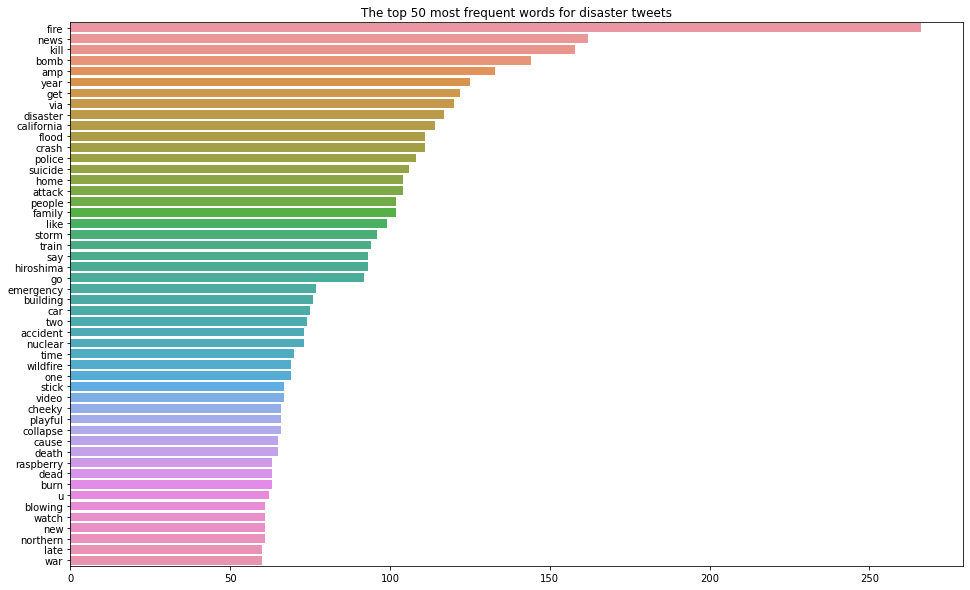

In [87]:
allWords_disaster=words_count(train_df,target=1)

plt.figure(figsize=(16,10))
counter=collections.Counter(allWords_disaster)
most_50_diaster=counter.most_common()
x=[]
y=[]
for word,count in most_50_diaster[:50]:
    x.append(word)
    y.append(count)
sns.barplot(x=y,y=x).set(title='The top 50 most frequent words for disaster tweets')

In [88]:
updated_feature_list.append(x)

In [92]:
flat_list = [item for sublist in updated_feature_list  for item in sublist]

In [93]:
print(len(flat_list))

100


In [94]:
# Let's collect these 100 words as features and put to model
X_bow_train_updated = X_bow_train.loc[:, X_bow_train.columns.isin(flat_list)]
X_bow_test_updated = X_bow_test.loc[:, X_bow_test.columns.isin(flat_list)]

In [95]:
# We can see that the TFDIF discard some words which are common across all documents.
print(X_bow_train_updated.shape, X_bow_test_updated.shape)

(7485, 83) (2158, 83)


In [98]:
# This method is still worse than PCA + SVC
SVC = svm.SVC()
pipe = Pipeline(steps=[("svc", SVC)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    "svc__C": [0.01, 0.1, 1, 10, 100],
    "svc__kernel" :['linear', 'rbf', 'poly']
}
search = GridSearchCV(pipe, param_grid)
search.fit(X_bow_train_updated, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.678):
{'svc__C': 1, 'svc__kernel': 'rbf'}
